<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.


In [ ]:
pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 1.0 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install lightgbm

In [ ]:
pip install --upgrade pillow

     |████████████████████████████████| 3.4 MB 1.8 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!/opt/conda/bin/python -m pip install wordcloud
#!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2

     |████████████████████████████████| 460 kB 1.8 MB/s eta 0:00:01


## Подготовка

In [ ]:
#импорты из стандартной бибилиотеки
import numpy as np
import matplotlib.pyplot as plt
import operator
import pandas as pd
import re
import torch
import string

#импорты сторонних библиотек
import nltk
import lightgbm as lgb
import transformers

#импорты модулей текущего проекта
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from tqdm import notebook
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
RANDOM = 42

In [ ]:
df_toxic= pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col = 0)

In [ ]:
df_toxic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
df_toxic.sample(10)

,text,toxic
11752,"""\n\nFair use rationale for Image:AnimaPromoti...",0
87099,"""\n\n A barnstar for you! \n\n The Original B...",0
127439,"Huh? I think your on a different page, Tom. .....",0
53950,June 2007\n Talk / Contribs,0
119854,Length \n\nThe length of the bus fleet has bee...,0
61193,"""Welcome!\n\nHello, , and welcome to Wikipedia...",0
42426,Eric W.Bragg's Surrealism: SIDEWALK STAINS\n\n...,1
30731,"""\n\n Adrian Crowley \n\nHi, just a few minor ...",0
11491,nesoi alternate definition \n\nNESOI is short ...,0
73875,"""\n At this time there is no backlog of reque...",0


In [ ]:
#переведем текст в нижний регистр для уменьшения количества вариантов слов
df_toxic['text']= df_toxic['text'].str.lower()

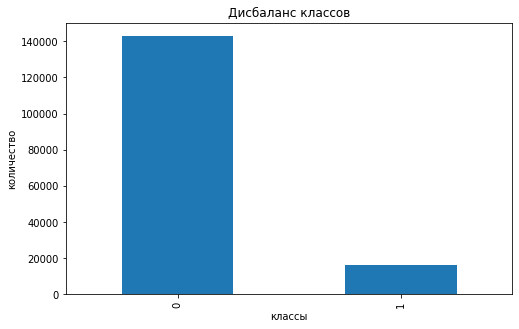

In [ ]:
#оценим сбалансированность классов целевой переменной
df_toxic.groupby(['toxic'])['toxic'].count().plot.bar(
figsize =(8,5),
xlabel = 'классы',
ylabel = 'количество',
title = 'Дисбаланс классов'
)
plt.show()

Наблюдается сильный дисбаланс классов в таргете. Слишком много токсичных комментариев.

Лемматизируем и токенизируем данные, избавлясь от мусора. Лемматизация предложений проведена с помощью соответствующего POS-тега

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def text_tokenization_lemmatize(text):
    text_only = re.sub(r'[^a-zA-Z]', ' ', text)
    final = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text_only)])
    return final

In [ ]:
notebook.tqdm.pandas()
df_toxic['text_token'] = df_toxic['text'].progress_apply(text_tokenization_lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
negative_text = ' '.join(df_toxic.loc[df_toxic.toxic == 1, 'text'])
positive_text = ' '.join(df_toxic.loc[df_toxic.toxic == 0, 'text'])

In [ ]:
negative_tokens= word_tokenize(negative_text)
positive_tokens = word_tokenize(positive_text)

In [ ]:
negative_words = nltk.Text(negative_tokens)
positive_words = nltk.Text(positive_tokens)

In [ ]:
fdist_negative = FreqDist(negative_words)
fdist_negative

FreqDist({'!': 56241, 'you': 39971, '.': 36996, ',': 30827, 'i': 24363, 'the': 22917, 'a': 21991, 'to': 17474, 'and': 17396, 'is': 14075, ...})

In [ ]:
fdist_positive = FreqDist(positive_words)
fdist_positive

FreqDist({'the': 471461, '.': 442408, ',': 439751, 'to': 278604, "''": 227665, 'i': 211902, 'of': 210875, 'and': 204756, 'a': 191635, 'you': 175898, ...})

In [ ]:
df_negative = df_toxic[df_toxic['toxic'] == 1]
df_negative

,text,toxic,text_token
6,cocksucker before you piss around on my work,1,cocksucker before you piss around on my work
12,hey... what is it..\n@ | talk .\nwhat is it......,1,hey what be it talk what be it an exclusive gr...
16,"bye! \n\ndon't look, come or think of comming ...",1,bye don t look come or think of comming back t...
42,you are gay or antisemmitian? \n\narchangel wh...,1,you be gay or antisemmitian archangel white ti...
43,"fuck your filthy mother in the ass, dry!",1,fuck your filthy mother in the as dry
...,...,...,...
159374,"""\n\n our previous conversation \n\nyou fuckin...",1,our previous conversation you fuck shit eat li...
159394,you are a mischievious pubic hair,1,you be a mischievious pubic hair
159421,your absurd edits \n\nyour absurd edits on gre...,1,your absurd edits your absurd edits on great w...
159426,"""\n\nhey listen don't you ever!!!! delete my e...",1,hey listen don t you ever delete my edits ever...


In [ ]:
df_positive = df_toxic[df_toxic['toxic'] == 0]
df_positive

,text,toxic,text_token
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159446,""":::::and for the second time of asking, when ...",0,and for the second time of ask when your view ...
159447,you should be ashamed of yourself \n\nthat is ...,0,you should be ashamed of yourself that be a ho...
159448,"spitzer \n\numm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159449,and it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [ ]:
text_cloud = ' '.join(df_negative['text'])

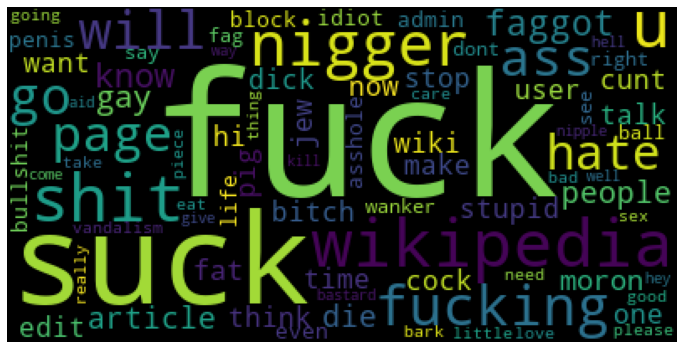

In [ ]:
cloud = WordCloud(max_words=80, collocations=False).generate(text_cloud)
plt.figure(figsize=(12,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
text_cloud = ' '.join(df_positive['text'])

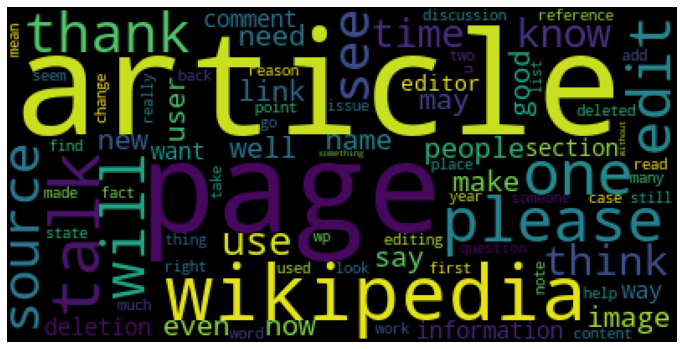

In [ ]:
cloud = WordCloud(max_words=80, collocations=False).generate(text_cloud)
plt.figure(figsize=(12,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
stop_words = list(stopwords.words('english'))
# print(len(stop_words))
# print(stop_words)
# stop_words.extend(first_data)

In [ ]:
# print(len(stop_words))
# print(stop_words)

In [ ]:
#проверяем после очистки частоту слов
#tokens_without_sw = [word for word in text_tokens if not word in stop_words]

In [ ]:
#tokens_without_sw

In [ ]:
# fdist_2 = FreqDist(tokens_without_sw)
# print(fdist_2)
# data = fdist_2.most_common()
# data

**Промежуточный вывод**   
Текст обработали:
1. перевела в нижний регистр
2. очистила от цифр, знаков, специальных символов
3. провела лемматизацию
4. сформировала облако из слов негативных и позитивных отзывов    



Готовим данные для обучения

In [ ]:
features = df_toxic['text_token']
target = df_toxic['toxic']

Делим выборку, выделяя тестовую в объеме 20 %, формируем признаки и таргет.

In [ ]:
features_train, features_test, target_train, target_test= train_test_split(features, target, test_size=0.2,
                                                                           random_state=RANDOM, stratify=target)
print(features_train.shape,features_test.shape)
print(target_train.shape, target_test.shape)

(127433,) (31859,)
(127433,) (31859,)


Оцениваем вес классов на выборках

In [ ]:
print('Распределение классов в обучающей выборке:')
print('0 = ',target_train.value_counts()[0] / target_train.value_counts().sum())
print('1 = ',target_train.value_counts()[1] / target_train.value_counts().sum())

print('Распределение классов в тестовой выборке:')
print('0 = ',target_test.value_counts()[0] / target_test.value_counts().sum())
print('1 = ',target_test.value_counts()[1] / target_test.value_counts().sum())

Распределение классов в обучающей выборке:
0 =  0.898385818430077
1 =  0.10161418156992302
Распределение классов в тестовой выборке:
0 =  0.8983960576289275
1 =  0.10160394237107254


## Обучение

Формируем таблицу результатов

In [ ]:
results = pd.DataFrame({
    'Model data' : [], 'Model learn' : [], 'best_score' : []
})

In [ ]:
pl_vc_LR = Pipeline([("Vectorizer", CountVectorizer(stop_words=stop_words)),
                     ("LR", LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced', random_state=RANDOM))])

In [ ]:
parameter_grid = [{
    #'Vectorizer__max_df': [0.1,0.5,1.0],
    #'Vectorizer__min_df': [1, 3, 5, 10],
    'Vectorizer__ngram_range': [(1, 1), (1, 2)],
    'LR__C': [0.1, 0.5, 10.]
}]

In [ ]:
gscv_1 = GridSearchCV(pl_vc_LR, parameter_grid, cv=5, refit=True, scoring='f1')
gscv_1.fit(features_train,target_train)
prediction = gscv_1.predict(features_train)
print('Лучшие параметры модели: ', gscv_1.best_params_)
print('Лучшее значение метрики: ', gscv_1.best_score_)

Лучшие параметры модели:  {'LR__C': 0.5, 'Vectorizer__ngram_range': (1, 2)}
Лучшее значение метрики:  0.7831239799833262


In [ ]:
model_data = str(pl_vc_LR[0]).split(sep='(')[0]
name_mod = str(pl_vc_LR[1]).split(sep='(')[0]

In [ ]:
globals()['results']= globals()['results'].append({
                                                   'Model data' : model_data, 'Model learn' : name_mod,
                                                   'best_score' : gscv_1.best_score_},
                                                   ignore_index=True
)

In [ ]:
pl_fd_LR = Pipeline([("TfidfVectorizer", TfidfVectorizer(stop_words=stop_words)),
                     ("LR", LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced', random_state=RANDOM))])

In [ ]:
parameter_grid = [{
    'TfidfVectorizer__ngram_range': [(1, 1), (1, 2)],
    'LR__C': [0.1, 10.]
}]

In [ ]:
gstf_1 = GridSearchCV(pl_fd_LR, parameter_grid, cv=5, refit=True,  scoring='f1')
gstf_1.fit(features_train,target_train)
prediction = gscv_1.predict(features_train)
print('Лучшие параметры модели: ', gstf_1.best_params_)
print('Лучшее значение метрики: ', gstf_1.best_score_)

Лучшие параметры модели:  {'LR__C': 10.0, 'TfidfVectorizer__ngram_range': (1, 2)}
Лучшее значение метрики:  0.7820317757073544


In [ ]:
model_data = str(pl_fd_LR[0]).split(sep='(')[0]
name_mod = str(pl_fd_LR[1]).split(sep='(')[0]
globals()['results']= globals()['results'].append({
                                                   'Model data' : model_data, 'Model learn' : name_mod,
                                                   'best_score' : gstf_1.best_score_},
                                                   ignore_index=True
)

Обучим модели с использованием Bert модели.

## Выводы

In [ ]:
results = results.sort_values('best_score', ascending=False)
results

,Model data,Model learn,best_score
0,CountVectorizer,LogisticRegression,0.783124
1,TfidfVectorizer,LogisticRegression,0.782032


In [ ]:
predict =  gscv_1.predict(features_test)
test_f1 = f1_score(target_test, predict)
print('F1_score на тестовой выборке:',test_f1)

F1_score на тестовой выборке: 0.78693575720228


**Вывод**   
Лучшие значения метрики качества на полном датасете оказались у логистической регрессии на "мешке слов" с результатом 0,7831. На тестовой выборке F1_score достигнут заданной величины более 0,75.

Наилучший результат на тесте показала модель LogisticRegression на предобработанном тексте с помощью модели CountVectorizer.